# Running XGBoost on Predictors 

#### Initialize the data matrix holding feature data and criticality labels

In [103]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

df = pd.read_csv("dataset.csv", sep=',', encoding='latin-1')
d={"negative":0, "positive":1,"not_detected":0,"detected":1}
df=df.replace(d)
df=df.loc[(df['SARS-Cov-2 exam result'] == 1)]
#df=df.drop(['SARS-Cov-2 exam result','Patient addmited to intensive care unit (1=yes, 0=no)','Patient addmited to semi-intensive unit (1=yes, 0=no)','Patient addmited to regular ward (1=yes, 0=no)'], axis=1)

#New feature & correlation set with only strong features
df_feat=df[['Base_excess_arterial','Total_CO2_arterial','HCO3_arterial','hs-CRP_mg/dL','Alanine_transaminase', 'Lactic_Dehydrogenase', 'Neutrophils', 'Lipase_dosage','Arterial_Lactic_Acid','criticality']];

X,y =df_feat.iloc[:,:-1], df_feat.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
y.value_counts()

0    506
1     36
3      8
2      8
Name: criticality, dtype: int64

#### Split into training and testing sets. Due to the low occurance of higher criticality levels (3 & 4), we use a 70/30 approach to ensure the model can be trained on each criticality level.

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify=y)

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape,

((390, 9), (390,), (168, 9), (168,))

#### Set parameters

In [87]:
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4,
    'n_gpus': 0
}

#### Train model on parameters and training data

In [96]:
bst = xgb.train(params, dtrain)
pred = bst.predict(dtest)


#### Print classification report with metrics

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       152
           1       0.62      0.45      0.53        11
           2       0.33      0.33      0.33         3
           3       0.50      0.50      0.50         2

    accuracy                           0.93       168
   macro avg       0.61      0.57      0.58       168
weighted avg       0.93      0.93      0.93       168



## K-fold Validation Technique using multiple splits

In [104]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=50,early_stopping_rounds=10,metrics="merror", as_pandas=True, seed=123)

In [105]:
cv_results.head()
print((cv_results["test-merror-mean"]).tail(1))

12    0.082403
Name: test-merror-mean, dtype: float64


## Visualize tree-splitting

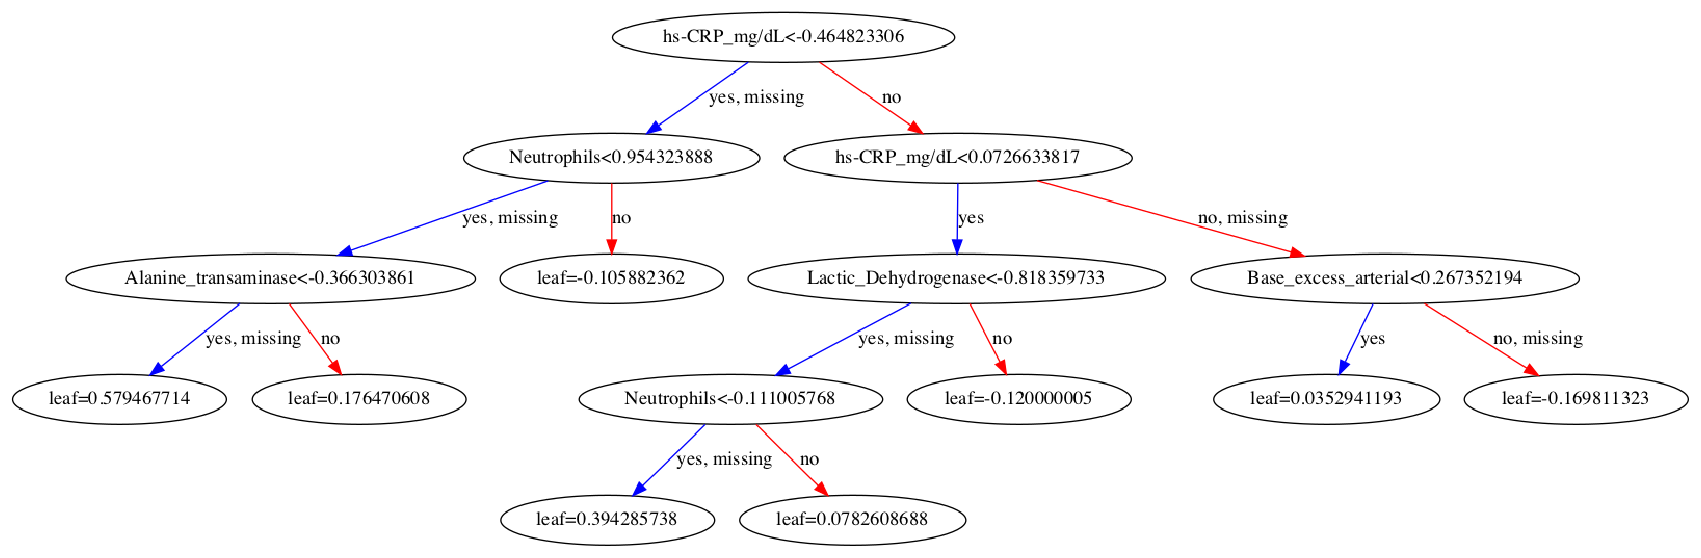

In [91]:
import matplotlib.pyplot as plt

xgb.plot_tree(bst,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

## Confusion Matrix

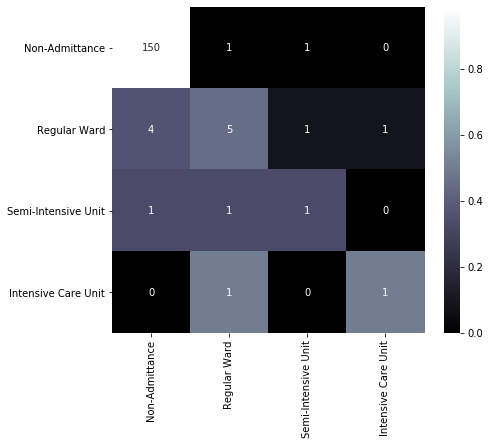

In [106]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, pred)
cm

import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
        plt.savefig('confusion-matrix.png')

plot_confusion_matrix(cm, ['Non-Admittance', 'Regular Ward', 'Semi-Intensive Unit', 'Intensive Care Unit'])


## Feature Importance

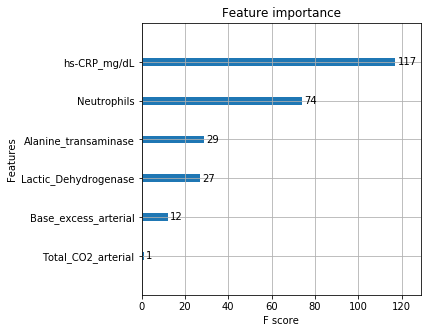

In [102]:
xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()